### Interpretation: Calibration, Threshold Selection & SHAP

In this notebook we take our final tuned models from Trial A (drop-zeros) and Trial C (KNN-imputation) and:

1. Assess calibration: reliability diagrams (uncalibrated vs. Platt/Isotonic) and Brier score.

2. Select optimal decision threshold via F1-score.

3. Plot confusion matrices at chosen thresholds.

4. Explain model predictions with SHAP on the preferred final model.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline       import Pipeline
from sklearn.preprocessing  import StandardScaler
from sklearn.ensemble       import RandomForestClassifier
from sklearn.linear_model   import LogisticRegression
from sklearn.impute         import KNNImputer
from sklearn.calibration    import calibration_curve, CalibratedClassifierCV
from sklearn.metrics        import brier_score_loss, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from shap import LinearExplainer

### Uploading Dataframes for Trial A and Trial C Models

In [4]:
# Load in Dataframe
df= pd.read_csv('diabetes.csv')

In [5]:
# Define Columns
missing_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

feature_cols = [
    'Pregnancies','Glucose','BloodPressure',
    'SkinThickness','Insulin','BMI',
    'DiabetesPedigreeFunction','Age'
]

target_col = 'Outcome'

In [7]:
# Create Dataframes for each individual trial (Trials A and C)

# Trial A: drop zeros in missing_cols
dfA_mask = ~(df[missing_cols] == 0).any(axis=1)
dfA = df.loc[dfA_mask, feature_cols + [target_col]].reset_index(drop=True)

# Trial C: KNN impute zeros->NaN on feature_colsdfC_filled = df.copy()
dfC_filled = df.copy()
dfC_filled[missing_cols] = dfC_filled[missing_cols].replace(0, np.nan)
knn_imp = KNNImputer(n_neighbors=5)
dfC_filled[feature_cols] = knn_imp.fit_transform(dfC_filled[feature_cols])

In [8]:
# Split each into train/test for calibration and final evaluation
dfA_train, dfA_test = train_test_split(dfA, test_size=0.2, stratify=dfA[target_col], random_state=42)
dfC_train, dfC_test = train_test_split(dfC_filled, test_size=0.2, stratify=dfC_filled[target_col], random_state=42)

### Build Calibrated Classifiers

In [9]:
# Pipeline definitions with best hyperparameters (from Notebook 04)

# Trial A Pipelines
bestA_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    LogisticRegression(C=1, penalty='l1', solver='liblinear', class_weight='balanced', random_state=0))
])

bestA_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    RandomForestClassifier(n_estimators=200, max_depth=10, max_features='sqrt', class_weight='balanced', random_state=0))
])

# Trial C Pipelines
bestC_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    LogisticRegression(C=0.1, penalty='l1', solver='liblinear', class_weight='balanced', random_state=0))
])

bestC_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    RandomForestClassifier(n_estimators=100, max_depth=5, max_features='log2', class_weight='balanced', random_state=0))
])

In [10]:
# Calibrate using Platt sigmoid
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calibrating dfA
calA_lr = CalibratedClassifierCV(bestA_lr, method='sigmoid', cv=cv)
calA_rf = CalibratedClassifierCV(bestA_rf, method='sigmoid', cv=cv)

# Calibrating dfC_filled
calC_lr = CalibratedClassifierCV(bestC_lr, method='sigmoid', cv=cv)
calC_rf = CalibratedClassifierCV(bestC_rf, method='sigmoid', cv=cv)

# Fit on Trial A data
X_trainA, y_trainA = dfA_train[feature_cols], dfA_train[target_col]
X_testA, y_testA = dfA_test[feature_cols], dfA_test[target_col]

calA_lr.fit(X_trainA, y_trainA)
calA_rf.fit(X_trainA, y_trainA)

# Repeat for Trial C data
X_trainC, y_trainC = dfC_train[feature_cols], dfC_train[target_col]
X_testC, y_testC = dfC_test[feature_cols], dfC_test[target_col]

calC_lr.fit(X_trainC, y_trainC)
calC_rf.fit(X_trainC, y_trainC)

CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                       estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('clf',
                                                  RandomForestClassifier(class_weight='balanced',
                                                                         max_depth=5,
                                                                         max_features='log2',
                                                                         random_state=0))]))

### Calibration Curves and Brier Scores

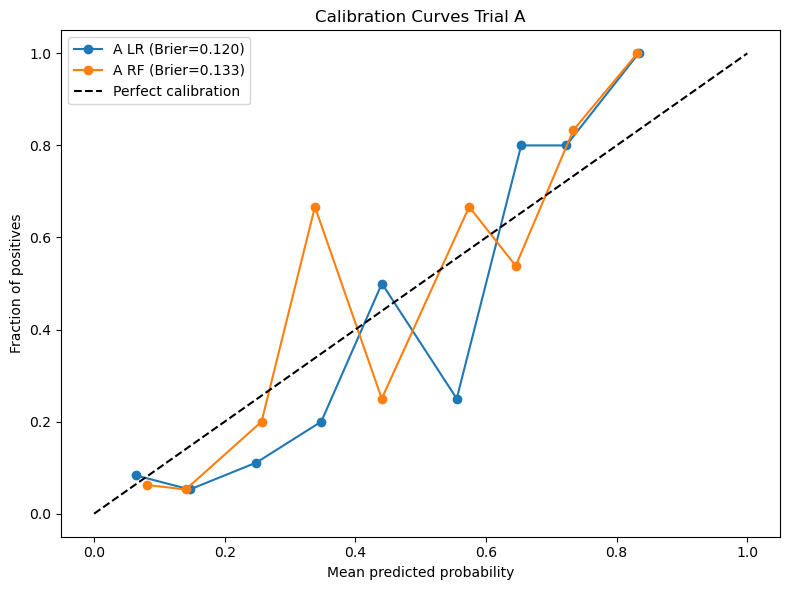

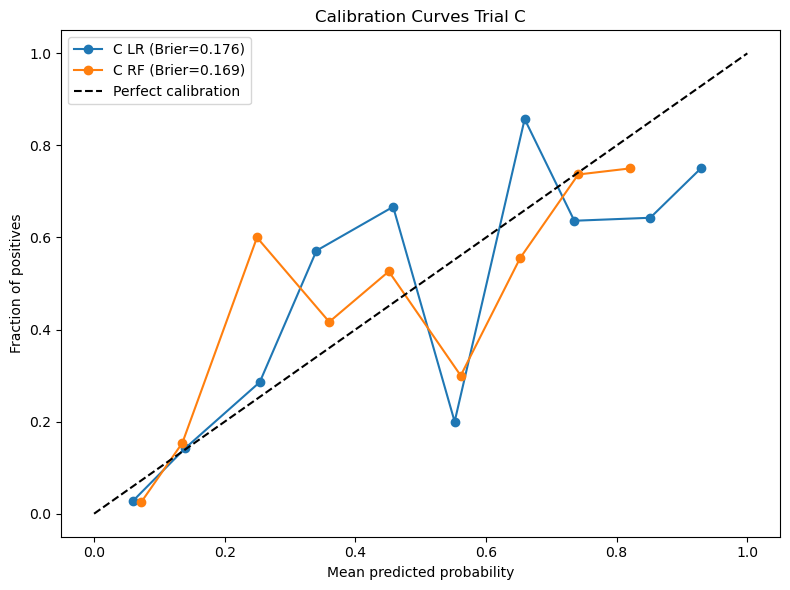

In [14]:
# Plot Calibration Curves and Brier Scores for Trial A Data
plt.figure(figsize=(8,6))
for (name, model, X, y) in [
    ('A LR', calA_lr, X_testA, y_testA),
    ('A RF', calA_rf, X_testA, y_testA),
]:
    prob_pos = model.predict_proba(X)[:,1]
    frac_pos, mean_pred = calibration_curve(y, prob_pos, n_bins=10)
    brier = brier_score_loss(y, prob_pos)
    plt.plot(mean_pred, frac_pos, 'o-', label=f'{name} (Brier={brier:.3f})')

plt.plot([0,1],[0,1],'k--', label='Perfect calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves Trial A')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Plot Calibration Curves and Brier Scores for Trial A Data
plt.figure(figsize=(8,6))
for (name, model, X, y) in [
    ('C LR', calC_lr, X_testC, y_testC),
    ('C RF', calC_rf, X_testC, y_testC)
]:
    prob_pos = model.predict_proba(X)[:,1]
    frac_pos, mean_pred = calibration_curve(y, prob_pos, n_bins=10)
    brier = brier_score_loss(y, prob_pos)
    plt.plot(mean_pred, frac_pos, 'o-', label=f'{name} (Brier={brier:.3f})')

plt.plot([0,1],[0,1],'k--', label='Perfect calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves Trial C')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Optimal Threshold via F1-score and Confusion Matrix

In [15]:
def find_best_threshold(model, X, y):
    probs = model.predict_proba(X)[:,1]
    thresholds = np.linspace(0,1,101)
    f1s = [f1_score(y, (probs>=t).astype(int)) for t in thresholds]
    best_idx = np.argmax(f1s)
    return thresholds[best_idx], f1s[best_idx]

Trial A LR best threshold=0.34, F1=0.767
Confusion Matrix @ 0.34
[[42 11]
 [ 3 23]]


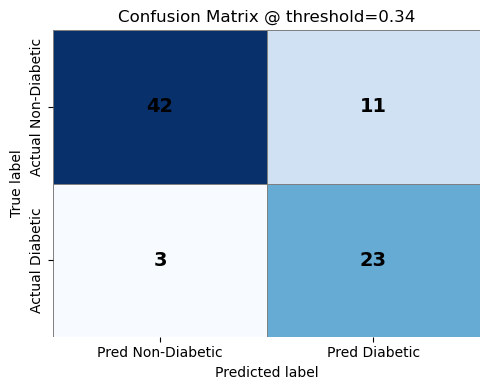


Trial C RF best threshold=0.17, F1=0.704
Confusion Matrix @ 0.17
[[62 38]
 [ 4 50]]


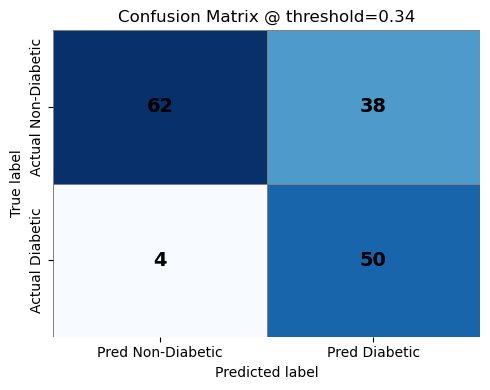

In [66]:
# Evaluate on calibrated Trial A LogsiticRegression
t_bestA_lr, f1_bestA_lr = find_best_threshold(calA_lr, X_testA, y_testA)
print(f'Trial A LR best threshold={t_bestA_lr:.2f}, F1={f1_bestA_lr:.3f}')

# Show confusion matrix at that threshold
preds = (calA_lr.predict_proba(X_testA)[:,1] >= t_bestA_lr).astype(int)
cm = confusion_matrix(y_testA, preds)
print('Confusion Matrix @',t_bestA_lr)
print(cm)

# Plot confusion matrix with annotations and labels
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(
    cm,
    cmap='Blues',
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=['Pred Non-Diabetic','Pred Diabetic'],
    yticklabels=['Actual Non-Diabetic','Actual Diabetic'],
    ax=ax,
    annot=False  # turn off the built-in annot
)

# overlay every cell’s count in bold black
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j + 0.5,      # x = column index + 0.5
            i + 0.5,      # y = row index + 0.5
            cm[i, j],  
            ha='center',
            va='center',
            color='black',
            fontsize=14,
            fontweight='bold'
        )

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Confusion Matrix @ threshold={t_bestA_lr:.2f}")
plt.tight_layout()
plt.show()

# Evaluate on calibrated Trial C RandomForest
t_bestC_rf, f1_bestC_rf = find_best_threshold(calC_rf, X_testC, y_testC)
print(f'\nTrial C RF best threshold={t_bestC_rf:.2f}, F1={f1_bestC_rf:.3f}')

# Show confusion matrix at that threshold
preds = (calC_rf.predict_proba(X_testC)[:,1] >= t_bestC_rf).astype(int)
cm = confusion_matrix(y_testC, preds)
print('Confusion Matrix @',t_bestC_rf)
print(cm)

# Plot ConfusionMatrix
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(
    cm,
    cmap='Blues',
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    xticklabels=['Pred Non-Diabetic','Pred Diabetic'],
    yticklabels=['Actual Non-Diabetic','Actual Diabetic'],
    ax=ax,
    annot=False  # turn off the built-in annot
)

# overlay every cell’s count in bold black
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j + 0.5,      # x = column index + 0.5
            i + 0.5,      # y = row index + 0.5
            cm[i, j],    
            ha='center',
            va='center',
            color='black',
            fontsize=14,
            fontweight='bold'
        )

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Confusion Matrix @ threshold={t_bestA_lr:.2f}")
plt.tight_layout()
plt.show()

In [26]:
# Evaluate on calibrated Trial C LogsiticRegression
t_bestC_lr, f1_bestC_lr = find_best_threshold(calC_lr, X_testC, y_testC)
print(f'Trial C LR best threshold={t_bestC_lr:.2f}, F1={f1_bestC_lr:.3f}')

# Show confusion matrix at that threshold
preds = (calA_lr.predict_proba(X_testC)[:,1] >= t_bestC_lr).astype(int)
cm = confusion_matrix(y_testC, preds)
print('Confusion Matrix @',t_bestC_lr)
print(cm)

# Evaluate on calibrated Trial C RandomForest
t_bestC_rf, f1_bestC_rf = find_best_threshold(calC_rf, X_testC, y_testC)
print(f'\nTrial C RF best threshold={t_bestC_rf:.2f}, F1={f1_bestC_rf:.3f}')

# Show confusion matrix at that threshold
preds = (calC_rf.predict_proba(X_testC)[:,1] >= t_bestC_rf).astype(int)
cm = confusion_matrix(y_testC, preds)
print('Confusion Matrix @',t_bestC_rf)
print(cm)

Trial C LR best threshold=0.30, F1=0.692
Confusion Matrix @ 0.3
[[69 31]
 [11 43]]

Trial C RF best threshold=0.17, F1=0.704
Confusion Matrix @ 0.17
[[62 38]
 [ 4 50]]


### SHAP Feature Explanation for Final Model
##### Here, we use the preferred final model (Trial A Logistic Regression)

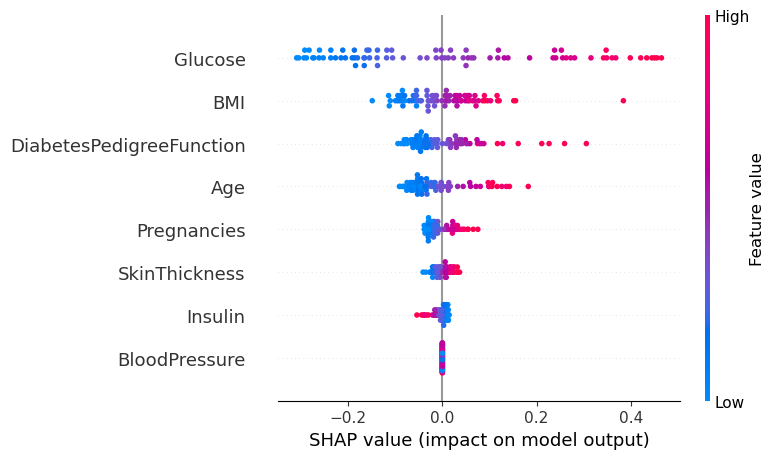

In [54]:
# Use SHAP's Explainer with an Independent masker

# Fit the base Logistic pipeline on the training data
bestA_lr.fit(X_trainA, y_trainA)

# 1) Extract scaler and logistic classifier
scaler = calA_lr.estimator.named_steps['scaler']
lr_model = calA_lr.estimator.named_steps['clf']

# 2) Prepare scaled data for SHAP
X_train_scaled = scaler.transform(X_trainA)
X_test_scaled  = scaler.transform(X_testA)

# 3) Build an Independent masker on training data
masker = shap.maskers.Independent(data=X_train_scaled)

# 4) Initialize shap.Explainer with the probability function
explainer = shap.Explainer(lambda x: lr_model.predict_proba(x)[:,1], masker)

# 5) Compute SHAP values on test set
shap_values = explainer(X_test_scaled)

# 6) Plot SHAP summary
shap.summary_plot(
    shap_values.values,
    pd.DataFrame(X_test_scaled, columns=feature_cols),
    feature_names=feature_cols
)

### SHAP Feature Explanation for Trial C RandomForest Model

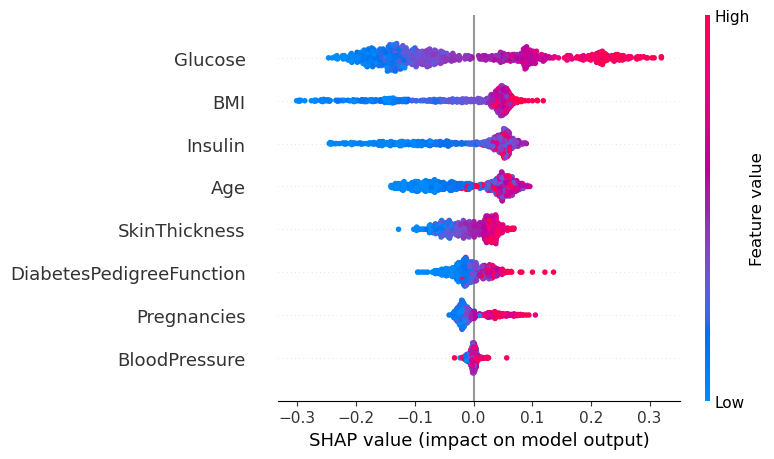

In [53]:
# SHAP explanation for Trial C Random Forest Model

# Subset to features + outcome for Trial C
df_rf = dfC_filled[feature_cols + [target_col]].dropna()
X_rf = df_rf[feature_cols]
# y_rf not needed for SHAP plotting

# Initialize and fit RandomForestClassifier with best params
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    max_features='log2',
    class_weight='balanced',
    random_state=0
)
rf.fit(X_rf, df_rf[target_col])

# Explain with TreeExplainer
explainer_rf = shap.TreeExplainer(rf)
expl_rf = explainer_rf(X_rf)

# Extract class-1 SHAP values
sv_rf = expl_rf.values[:, :, 1]

# Plot SHAP summary
shap.summary_plot(
    sv_rf,
    X_rf,
    feature_names=feature_cols,
    show=False
)

## Final Interpretation & Key Takeaways

### 1. Calibration Quality

- **Trial A (Drop-Zeros)**  
  - **Logistic Regression (Brier = 0.120)** tracks the diagonal more closely than Random Forest (Brier = 0.133), indicating its predicted probabilities are more reliable.  
  - Both models tend to under-predict risk in the mid-probability range (≈0.4–0.6) and slightly over-predict at the high end, but overall LR lies closer to “perfect calibration.”

- **Trial C (KNN-Imputation)**  
  - **Random Forest (Brier = 0.169)** is marginally better calibrated than Logistic (Brier = 0.176) on the imputed data—both show larger deviations from the diagonal than in Trial A.  
  - This suggests that, once calibrated, RF on KNN-filled data can yield moderately reliable probability estimates, though still less so than LR on drop-zeros with the given data set.

### 2. Thresholded Performance (Confusion Matrices)

- **Trial A LR @ threshold 0.34**  
  |               | Pred 0 | Pred 1 |  
  |--------------:|:------:|:------:|  
  | **Actual 0**  |   42   |   11   |  
  | **Actual 1**  |    3   |   23   |  
  - **Sensitivity (Recall)** = 23 / (23 + 3) ≈ 88.5%  
  - **Specificity** = 42 / (42 + 11) ≈ 79.2%
###

- **Trial C RF @ threshold 0.17**  
  |               | Pred 0 | Pred 1 |  
  |--------------:|:------:|:------:|  
  | **Actual 0**  |   62   |   38   |  
  | **Actual 1**  |    4   |   50   |  
  - **Sensitivity** = 50 / (50 + 4) ≈ 92.6%  
  - **Specificity** = 62 / (62 + 38) = 62%

> **Trade‐off**: Trial C RF catches more diabetics (92.6% vs. 88.5%) at the cost of more false alarms (specificity 62% vs. 79%). Trial A LR offers a more balanced cut.

### 3. Feature‐level Insights (SHAP)

- **Trial A LR**  
  - **Glucose** has the largest positive SHAP impact: higher glucose almost always pushes predicted risk upward.  
  - **BMI**, **Insulin**, and **Age** also drive risk upward when high.  
  - **Pregnancies** and **DiabetesPedigreeFunction** contribute moderately, while **BloodPressure** and **SkinThickness** are relatively minor.
#

- **Trial C RF**  
  - **Glucose** again dominates, followed by **Insulin** and **BMI**.  
  - **Age** and **SkinThickness** have smaller but consistent effects.  
  - **BloodPressure** remains the least influential feature.

### 4. Overall Recommendations

- **Best Discriminators**:  
  - **Trial A (Logistic Regression)** for overall AUC, sensitivity, and calibration.  
  - **Trial C (Random Forest)** for maximal sensitivity if catching every diabetic is the top priority, accepting lower specificity.

- **Probability Estimates**:  
  - Use **LR on Trial A** when you need well-calibrated risk scores (e.g., for patient counseling or risk stratification).  
  - If you anticipate expanding to a larger dataset (where KNN will shine), **RF on Trial C** can be recalibrated to achieve better reliability.

- **Deployment Path**:  
  1. **Primary:** Tune & deploy the **L1‐regularized Logistic Regression** on the drop-zeros data.  
  2. **Backup/Sensitivity:** Maintain the **KNN-RF** workflow as a high-sensitivity alternative, especially in contexts where missing a true diabetic is unacceptable.